In [1]:
"""
https://github.com/CountingMstar/AI_BERT
"""

import requests
import json
import torch
import os
from tqdm import tqdm

In [2]:
"""
Import train dataset and validation dataset
"""
import pickle

with open('./data/train_contexts.pkl', 'rb') as f:
    contexts = pickle.load(f)
with open('./data/train_questions.pkl', 'rb') as f:
    questions = pickle.load(f)
with open('./data/train_answers.pkl', 'rb') as f:
    answers = pickle.load(f)

In [3]:
import random

k = 300
index_len = [i for i in range(len(contexts))]
train_index, val_index = [], []

for i in range(k):
  a = random.randint(0, len(contexts)-1)       
  while a in val_index : 
    a = random.randint(0, len(contexts)-1)
  val_index.append(a) 

for i in index_len:
    if i not in val_index:
        train_index.append(i)

In [4]:
print(len(index_len))
print(len(train_index))
print(len(val_index))

3264
2964
300


In [5]:
train_contexts, train_questions, train_answers = [], [], []
valid_contexts, valid_questions, valid_answers = [], [], []

for i in index_len:
    if i in train_index:
        train_contexts.append(contexts[i])
        train_questions.append(questions[i])
        train_answers.append(answers[i])
    elif i in val_index:
        valid_contexts.append(contexts[i])
        valid_questions.append(questions[i])
        valid_answers.append(answers[i]) 

print(len(train_contexts))
print(len(train_questions))
print(len(train_answers))
print()
print(len(valid_contexts))
print(len(valid_questions))
print(len(valid_answers))

2964
2964
2964

300
300
300


In [6]:
print(len(train_contexts))
print(len(train_questions))
print(len(train_answers))
print()
print(len(valid_contexts))
print(len(valid_questions))
print(len(valid_answers))

2964
2964
2964

300
300
300


In [7]:
"""
Import tokenizer and tokenizing the sentences
"""
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
valid_encodings = tokenizer(valid_contexts, valid_questions, truncation=True, padding=True)

In [8]:
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [9]:
no_of_encodings = len(train_encodings['input_ids'])
print(f'We have {no_of_encodings} context-question pairs')

We have 2964 context-question pairs


In [10]:
train_encodings['input_ids'][0]

[101,
 3444,
 3330,
 2030,
 3444,
 14676,
 2030,
 3444,
 5456,
 2003,
 1996,
 2832,
 1997,
 14817,
 2075,
 2838,
 1006,
 6459,
 1010,
 5144,
 1010,
 12332,
 1007,
 2013,
 6315,
 2951,
 1012,
 2349,
 2000,
 2784,
 4083,
 6125,
 1010,
 2107,
 2004,
 9530,
 6767,
 7630,
 3508,
 2389,
 15756,
 6125,
 1010,
 2008,
 2024,
 2583,
 2000,
 4553,
 2838,
 2011,
 3209,
 1010,
 5884,
 1011,
 3563,
 1011,
 2241,
 3444,
 3330,
 2038,
 2468,
 15832,
 2005,
 4432,
 1998,
 4613,
 6364,
 1012,
 2060,
 4973,
 1997,
 2838,
 1999,
 5584,
 2421,
 1996,
 2810,
 1997,
 9812,
 3238,
 3616,
 2107,
 2004,
 9579,
 2193,
 1999,
 8331,
 10949,
 1025,
 2059,
 16371,
 21218,
 2102,
 2193,
 1999,
 3684,
 4651,
 1025,
 7905,
 14428,
 6155,
 2193,
 1999,
 19671,
 3370,
 1025,
 2810,
 1997,
 2034,
 20167,
 2015,
 1997,
 1996,
 5576,
 2107,
 2004,
 17826,
 3997,
 1997,
 4475,
 7300,
 1999,
 9760,
 1010,
 4385,
 1012,
 1012,
 102,
 2054,
 2003,
 3444,
 3330,
 1029,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 

In [11]:
tokenizer.decode(train_encodings['input_ids'][0])

'[CLS] feature engineering or feature extraction or feature discovery is the process of extracting features ( characteristics, properties, attributes ) from raw data. due to deep learning networks, such as convolutional neural networks, that are able to learn features by themselves, domain - specific - based feature engineering has become obsolete for vision and speech processing. other examples of features in physics include the construction of dimensionless numbers such as reynolds number in fluid dynamics ; then nusselt number in heat transfer ; archimedes number in sedimentation ; construction of first approximations of the solution such as analytical strength of materials solutions in mechanics, etc.. [SEP] what is feature engineering? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [12]:
"""
Charater start/end positions to token start/end positions
"""

def add_token_positions(encodings, answers):
  start_positions = []
  end_positions = []
  for i in range(len(answers)):
    start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
    end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

    # if start position is None, the answer passage has been truncated
    if start_positions[-1] is None:
      start_positions[-1] = tokenizer.model_max_length
    if end_positions[-1] is None:
      end_positions[-1] = tokenizer.model_max_length

  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(valid_encodings, valid_answers)

In [13]:
train_encodings['start_positions'][:10]

[1, 110, 512, 1, 60, 322, 1, 92, 233, 10]

In [14]:
class AI_Dataset(torch.utils.data.Dataset):
  def __init__(self, encodings):
    self.encodings = encodings
  def __getitem__(self, idx):
    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
  def __len__(self):
    return len(self.encodings.input_ids)

In [15]:
train_dataset = AI_Dataset(train_encodings)
valid_dataset = AI_Dataset(valid_encodings)

In [16]:
"""
Make dataloader
"""
from torch.utils.data import DataLoader

# Define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)

In [18]:
"""
Import question-answering model
"""
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")
# Check on the available device - use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Working on {device}')


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Working on cuda:0


In [29]:
"""
Train the AI BERT model which is good at AI area
"""
from transformers import AdamW
from torch import nn

N_EPOCHS = 10
optim = AdamW(model.parameters(), lr=5e-5)

# model = nn.DataParallel(model, device_ids = [0,1])   
model.to(device)
model.train()

losses = []
accuracies = []

for epoch in range(N_EPOCHS):
  model.train()
  loop = tqdm(train_loader, leave=True)
  total_loss = 0
  for batch in loop:
    optim.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    loss.backward()
    optim.step()

    loop.set_description(f'Epoch {epoch+1}')
    loop.set_postfix(loss=loss.item())

    total_loss += loss.item()


  model.eval()
  acc = []

  for batch in tqdm(valid_loader):
    with torch.no_grad():
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      start_true = batch['start_positions'].to(device)
      end_true = batch['end_positions'].to(device)
      
      outputs = model(input_ids, attention_mask=attention_mask)

      start_pred = torch.argmax(outputs['start_logits'], dim=1)
      end_pred = torch.argmax(outputs['end_logits'], dim=1)

      acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
      acc.append(((end_pred == end_true).sum()/len(end_pred)).item())

  acc = sum(acc)/len(acc)

  print('################ '+ 'Epoch' + str(epoch+1) +' ################')
  print('loss: ' + str(total_loss))
  print('acc: ' + str(acc))

  losses.append(total_loss)
  accuracies.append(acc)

  if (epoch+1) % 5 == 0:
    torch.save(model, "./models/AI_BERT_final_"+str(epoch+1)+".pth")


/home/vil/anaconda3/envs/MJ/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 19/19 [00:02<00:00,  8.47it/s]


################ Epoch1 ################
loss: 280.0143936276436
acc: 0.6282894736842105


100%|██████████| 19/19 [00:02<00:00,  8.43it/s]


################ Epoch2 ################
loss: 158.87601033598185
acc: 0.930921052631579


100%|██████████| 19/19 [00:02<00:00,  8.40it/s]


################ Epoch3 ################
loss: 26.87571990280412
acc: 0.9835526315789473


100%|██████████| 19/19 [00:02<00:00,  8.39it/s]


################ Epoch4 ################
loss: 8.658175481075887
acc: 0.9802631578947368


100%|██████████| 19/19 [00:02<00:00,  8.37it/s]


################ Epoch5 ################
loss: 4.310698158777086
acc: 0.9884868421052632


100%|██████████| 19/19 [00:02<00:00,  8.39it/s]


################ Epoch6 ################
loss: 3.0081231176736765
acc: 0.9868421052631579


100%|██████████| 19/19 [00:02<00:00,  8.40it/s]


################ Epoch7 ################
loss: 1.845845216892485
acc: 0.9851973684210527


100%|██████████| 19/19 [00:02<00:00,  8.40it/s]


################ Epoch8 ################
loss: 2.0135075658909045
acc: 0.9819078947368421


100%|██████████| 19/19 [00:02<00:00,  8.38it/s]


################ Epoch9 ################
loss: 4.997199724894017
acc: 0.9736842105263158


100%|██████████| 19/19 [00:02<00:00,  8.39it/s]


################ Epoch10 ################
loss: 6.917126256477786
acc: 0.9819078947368421


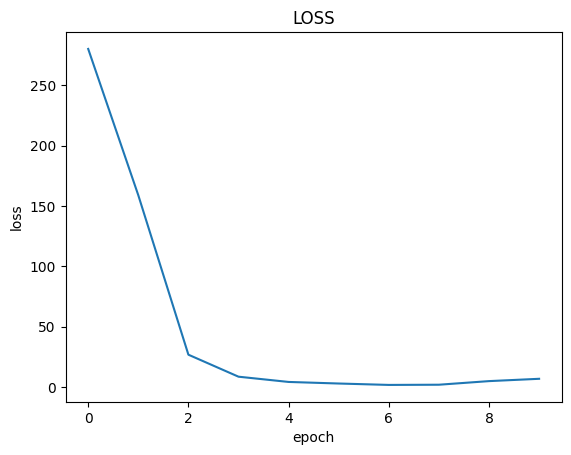

In [33]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('LOSS')
plt.show()

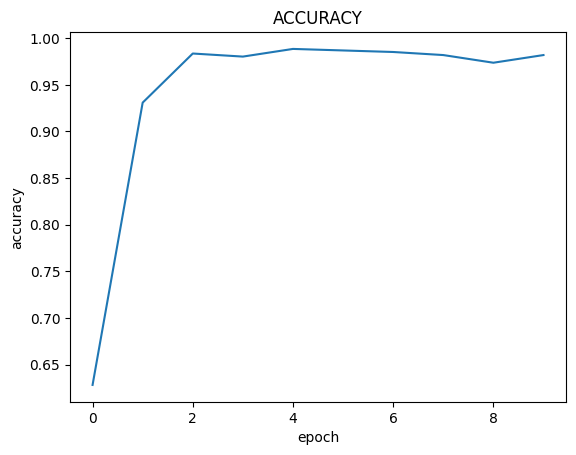

In [34]:
plt.plot(accuracies)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('ACCURACY')
plt.show()

In [20]:
"""
Test
"""

def get_prediction(context, question):
  inputs = tokenizer.encode_plus(question, context, return_tensors='pt').to(device)
  outputs = model(**inputs)
  
  answer_start = torch.argmax(outputs[0])  
  answer_end = torch.argmax(outputs[1]) + 1 
  
  answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
  
  return answer

def normalize_text(s):
  """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
  import string, re
  def remove_articles(text):
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    return re.sub(regex, " ", text)
  def white_space_fix(text):
    return " ".join(text.split())
  def remove_punc(text):
    exclude = set(string.punctuation)
    return "".join(ch for ch in text if ch not in exclude)
  def lower(text):
    return text.lower()

  return white_space_fix(remove_articles(remove_punc(lower(s))))

def exact_match(prediction, truth):
    return bool(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
  pred_tokens = normalize_text(prediction).split()
  truth_tokens = normalize_text(truth).split()
  
  # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
  if len(pred_tokens) == 0 or len(truth_tokens) == 0:
    return int(pred_tokens == truth_tokens)
  
  common_tokens = set(pred_tokens) & set(truth_tokens)
  
  # if there are no common tokens then f1 = 0
  if len(common_tokens) == 0:
    return 0
  
  prec = len(common_tokens) / len(pred_tokens)
  rec = len(common_tokens) / len(truth_tokens)
  
  return round(2 * (prec * rec) / (prec + rec), 2)
  
def question_answer(context, question,answer):
  prediction = get_prediction(context,question)
  em_score = exact_match(prediction, answer)
  f1_score = compute_f1(prediction, answer)

  print(f'Question: {question}')
  print(f'Prediction: {prediction}')
  print(f'True Answer: {answer}')
  print(f'Exact match: {em_score}')
  print(f'F1 score: {f1_score}\n')

In [21]:
model = torch.load("./models/AI_BERT_final_10.pth")

In [22]:
context =   """
            A large language model (LLM) is a type of language model notable for its ability to achieve 
            general-purpose language understanding and generation. LLMs acquire these abilities by using 
            massive amounts of data to learn billions of parameters during training and consuming large 
            computational resources during their training and operation.[1] LLMs are artificial neural 
            networks (mainly transformers[2]) and are (pre-)trained using self-supervised learning and 
            semi-supervised learning.
            """


questions = ["What is large language model?"]

answers = ["A large language model (LLM) is a type of language model notable for its ability to achieve general-purpose language understanding and generation."]

for question, answer in zip(questions, answers):
  question_answer(context, question, answer)

Question: What is large language model?
Prediction: a large language model ( llm ) is a type of language model notable for its ability to achieve general - purpose language understanding and generation.
True Answer: A large language model (LLM) is a type of language model notable for its ability to achieve general-purpose language understanding and generation.
Exact match: False
F1 score: 0.78

